In [1]:
# imorting libraries

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

In [2]:
# Define path for file with sonnets
SONNETS_FILE = 'sonnets.txt'

# Read the data
with open('sonnets.txt') as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


In [3]:
# Tokenizing the text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [5]:

tokenizer.texts_to_sequences([corpus[0]])
tokenizer.texts_to_sequences([corpus[0]])[0]

[[34, 417, 877, 166, 213, 517]]

In [6]:

def n_gram_seqs(corpus, tokenizer):
    """
    Generates a list of n-gram sequences

    Args:
        corpus (list of string): lines of texts to generate n-grams for
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary

    Returns:
        input_sequences (list of int): the n-gram sequences for each line in the corpus
    """
    input_sequences = []


    tokenized =tokenizer.texts_to_sequences(corpus)
    for token in tokenized:
      length =len(token)
      for i in range(1,length):
        input_sequences.append(token[:i+1])


    return input_sequences

In [7]:
# Test function with one example
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [8]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length for padding
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


In [9]:
def pad_seqs(input_sequences, maxlen):
    """
    Pads tokenized sequences to the same length

    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences

    Returns:
        padded_sequences (array of int): tokenized sequences padded to the same length
    """

    padded_sequences = pad_sequences(input_sequences,maxlen =maxlen)

    return padded_sequences


In [10]:
# Test your function with the n_grams_seq of the first example
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[  0,   0,   0,   0,  34, 417],
       [  0,   0,   0,  34, 417, 877],
       [  0,   0,  34, 417, 877, 166],
       [  0,  34, 417, 877, 166, 213],
       [ 34, 417, 877, 166, 213, 517]])

In [11]:

# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


In [12]:
def features_and_labels(input_sequences, total_words):
    """
    Generates features and labels from n-grams

    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size

    Returns:
        features, one_hot_labels (array of int, array of int): arrays of features and one-hot encoded labels
    """
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels, num_classes=total_words)

    return features, one_hot_labels

In [13]:
# Test your function with the padded n_grams_seq of the first example
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features

labels have shape: (5, 3211)

features look like this:



array([[  0,   0,   0,   0,  34],
       [  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213]])

In [14]:

# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


In [15]:

def create_model(total_words, max_sequence_len):
    """
    Creates a text generator model

    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text generator model
    """
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(total_words,activation ='softmax'))



    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


    return model

In [16]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=50, verbose=1)

Epoch 1/50
484/484 [==============================] - 10s 14ms/step - loss: 6.8885 - accuracy: 0.0237
Epoch 2/50
484/484 [==============================] - 7s 14ms/step - loss: 6.4686 - accuracy: 0.0260
Epoch 3/50
484/484 [==============================] - 7s 14ms/step - loss: 6.2922 - accuracy: 0.0350
Epoch 4/50
484/484 [==============================] - 7s 15ms/step - loss: 6.1032 - accuracy: 0.0433
Epoch 5/50
484/484 [==============================] - 7s 15ms/step - loss: 5.8986 - accuracy: 0.0521
Epoch 6/50
484/484 [==============================] - 7s 15ms/step - loss: 5.6809 - accuracy: 0.0614
Epoch 7/50
484/484 [==============================] - 7s 15ms/step - loss: 5.4527 - accuracy: 0.0731
Epoch 8/50
484/484 [==============================] - 7s 15ms/step - loss: 5.2288 - accuracy: 0.0831
Epoch 9/50
484/484 [==============================] - 7s 15ms/step - loss: 5.0158 - accuracy: 0.0953
Epoch 10/50
484/484 [==============================] - 7s 15ms/step - loss: 4.8160 - accur

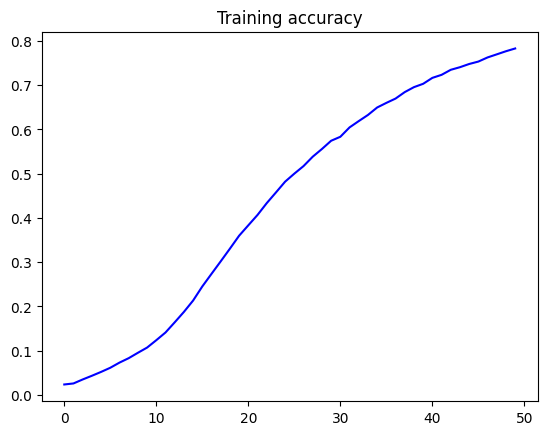

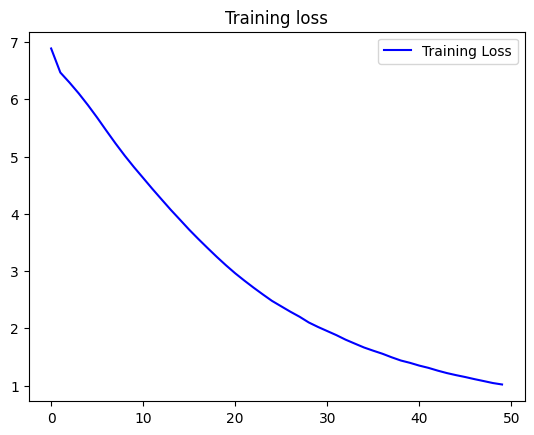

In [17]:
# Take a look at the training curves of your model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [18]:
# predicting words after the given text

seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100

for _ in range(next_words):
    # Convert the text into sequences
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    # Pad the sequences
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Get the probabilities of predicting a word
    predicted = model.predict(token_list, verbose=0)
    # Choose the next word based on the maximum probability
    predicted = np.argmax(predicted, axis=-1).item()
    # Get the actual word from the word index
    output_word = tokenizer.index_word[predicted]
    # Append to the current text
    seed_text += " " + output_word

print(seed_text)

Help me Obi Wan Kenobi, you're my only hope thy fair name telling up to flow violet perusal delighted splendor hid it quite growest so be a journey beauteous fair too much worth held bare impediments engrafted others toward space eyed lie from me my friend can be so well doth lie from me ill be not so such as mine fair true one best prey more even less in the spring of scorn to be minds back thence devise wide much is seen to too lie cruel true change best i know not bright in eyes shall lie is it shall lie but true a praise well could
